In [17]:
import sys
sys.path.insert(0, './signal_process.py')

import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import os
import signal_process
import librosa
from playsound import playsound


In [18]:
cwd = os.getcwd()
op_files = os.listdir(cwd + '/output/')
fs, signal = scipy.io.wavfile.read(cwd + '/output/complex.wav')
signal = signal[:, 0] #First Channel

In [19]:
def op_wavform(input_signal, f_samp):
    plt.gcf().clear()
    time = np.linspace(0, len(input_signal)/f_samp, num=len(input_signal))
    plt.title('Signal Waveform')
    plt.plot(time, input_signal)
    plt.show()
def op_pwelch(input_signal, f_samp, nfft_plot):
    plt.gcf().clear()
    freq, pdense = scipy.signal.welch(input_signal, fs=f_samp, window = 'hamming', nfft=nfft_plot)
    plt.title('Frequency Power Spectrum')
    plt.plot(freq, 10*np.log10(pdense))
    plt.show()
def plot_spectrogram(spectrogram):
    plt.matshow(np.sqrt(np.abs(spectrogram)).T, origin='lower', cmap='bone')
    plt.show()

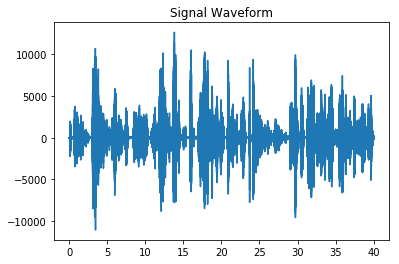

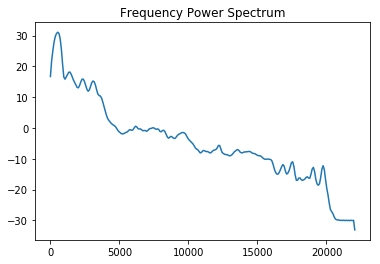

In [20]:
op_wavform(signal,fs)
op_pwelch(signal, fs, 500)
# op_wavform(signal_new,fs)
# op_pwelch(signal_new, fs, 257)

In [21]:
overlap = 0.018
window = 0.036
preemphasis = 0.95
sample_rate = 16000
nfft = 2*overlap*sample_rate
# op = signal_process.verify_COLA(window, overlap, sample_rate)

In [22]:
signal_lp = signal_process.low_pass_filt(signal, int(sample_rate/2), fs)
spectrogram = signal_process.make_stft_features(signal_lp, fs, sample_rate, window, overlap, preemphasis, nfft)
#Sample_rate, window_size, overlap, fft
X_input, phases, X_max, X_min = signal_process.featurize_spectrogram(spectrogram)
X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1]))

In [23]:
#Correct for normalisation
X_input = np.square(X_input*(X_max-X_min) + X_min)
complex_spectrogram = X_input[0, :, :]*np.exp(phases*1.0j)
#Need nfft = 2*overlap*sample_rate
waveform = signal_process.istft(complex_spectrogram, sample_rate, None,  overlap, two_sided=False, fft_size=nfft)
waveform = signal_process.undo_preemphasis(waveform)
waveform = (waveform - waveform.mean())/waveform.std()

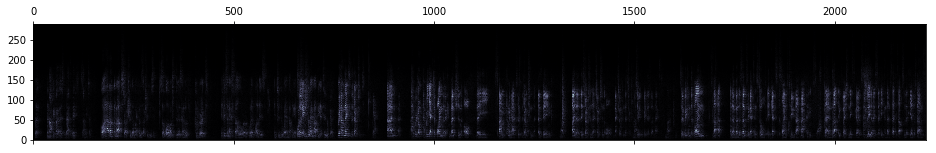

In [24]:
plot_spectrogram(spectrogram)

(641376,)


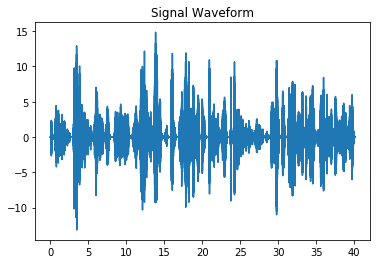

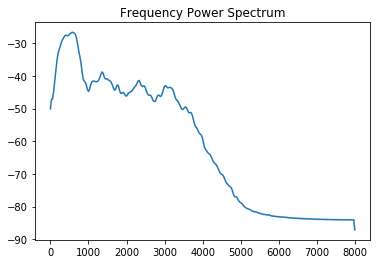

In [25]:
print(np.shape(waveform))
op_wavform(waveform,sample_rate)
op_pwelch(waveform, sample_rate, nfft)

In [26]:
# waveform = scipy.signal.wiener(waveform, 10)

In [27]:
scipy.io.wavfile.write(cwd + '/output/temp.wav',sample_rate, waveform[0:int(len(waveform)/14)]) #Demonstrate the first bit
playsound(cwd + '/output/temp.wav', block = False)

In [28]:
out_rate = 16000
signal_in = signal_process.low_pass_filt(signal, int(out_rate/2), fs)
resampled = scipy.signal.resample_poly(signal_in,100,int(100*fs/out_rate))
resampled = (resampled - resampled.mean())/resampled.std()

In [29]:
scipy.io.wavfile.write(cwd + '/output/complex_ds.wav', out_rate, resampled)